In [2]:
import sympy 
sympy.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control


import scipy.optimize
from tbcontrol.responses import fopdt, sopdt
from ipywidgets import interact

def resultplot1(K, tau, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, fopdt(ts, K, tau, theta, y0), color='red')
    plt.grid(True)

def resultplot2(K, tau, zeta, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, sopdt(ts, K, tau, zeta,theta, y0), color='red')
    plt.grid(True)
    


# PID

El controlador PID se compone de:
- Una acción Proporcional para brindar velocidad de respuesta y disminuir el error de estado estable
- Una acción Integral para eliminar el error de estado estable
- Una acción Derivativa para encargarse de errores cuando hay un cambio en el valor absoluto del error teniendo en cuenta que si el error es constante, solo actúan los modos proporcional e integral. 

La función de transferencia del PID es:

$$K_C\left ( 1 + \frac{1}{\tau_I s}+ \tau_D s \right )$$




La forma anterior no es realizable debido a la acción derivativa. Por esta razon, es común usar la forma:

$$K_C\left ( 1 + \frac{1}{\tau_I s}+ \frac{\tau_D s}{\alpha \tau_I s+1} \right )$$

donde se escoge $\alpha$ de manera que la parte derivativa sea una "buena" aproximación de la derivada.


## Diseño directo

Esta técnica parte del supuesto de definir el comportamiento deseado para el sistema en lazo cerrado, escribir una función de transferencia de lazo cerrado de una forma apropiada y despejar el compensador

<img src="figuras/standard_feedback.png" width=500em>

Partiendo del diagrama anterior, se define la relación deseada para $\frac{Y}{Y_{SP}}$ considerando $D=0$. Después se despeja $G_C$.

In [3]:
s, G_C = sympy.symbols('s, G_C')
G_C

Se parte de un modelo de primer orden más tiempo muerto como expresión deseada de $\frac{Y}{Y_{SP}}$.

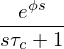

In [4]:
tau_c, phi = sympy.symbols('tau_c, phi', positive=True, nonzero=True)
desired_Y_over_Y_sp = sympy.exp(phi*s)/(tau_c*s + 1)
desired_Y_over_Y_sp

Recuerde la forma de la respuesta del sistema ante un escalón.

In [5]:
from ipywidgets import interact
t = sympy.Symbol('t', positive=True)
def plotresponse(theta=(0, 3.), tau_c_in=(1., 5.)):
    desired_response = sympy.inverse_laplace_transform(desired_Y_over_Y_sp.subs({phi: -theta, tau_c: tau_c_in})/s, s, t)
    p = sympy.plot(desired_response, (t, 0, 10), show=False)
    p2 = sympy.plot(1, (t, 0, 10), show=False)
    p.append(p2[0])
    p.show()
interact(plotresponse);

interactive(children=(FloatSlider(value=1.5, description='theta', max=3.0), FloatSlider(value=3.0, description…

A partir de un modelo aproximado para el proceso $\widetilde{G_P}$, puede calcularse la función de transferencia de lazo cerrado.

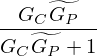

In [6]:
GPtilde = sympy.Symbol(r'\widetilde{G_P}')
actual_Y_over_Y_sp = GPtilde*G_C/(1 + GPtilde*G_C)
actual_Y_over_Y_sp

$$\frac{G_c(s)\widetilde{G_P}}{1+G_c(s)\widetilde{G_P}} = FdTLC_{deseada} = \frac{1}{\tau_c s + 1}e^{\phi s}$$

$$\frac{G_c(s)\widetilde{G_P}}{1+G_c(s)\widetilde{G_P}} -\frac{1}{\tau_c s + 1}e^{\phi s} = 0$$

$$\frac{1}{\tau_c s + 1}e^{\phi s} - \frac{G_c(s)\widetilde{G_P}}{1+G_c(s)\widetilde{G_P}}  = 0$$

En este punto, podría encontrarse el compensador al resolver la igualdad con la función de transferencia  deseada para el sistema en lazo cerrado.

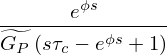

In [7]:
G_C_solved, = sympy.solve(desired_Y_over_Y_sp - actual_Y_over_Y_sp, G_C)
G_C_solved

Esta función de transferencia tiene $e^{\phi s}$ en el numerador y en el denominador.  
- El significado de la exponencial en el numerador es de desplazamiento temporal (tiempo muerto).
- El denominador se aproxima mediante una expansión de serie de Taylor de primer orden.

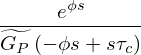

In [8]:
denom = sympy.denom(G_C_solved)
G_C_rational = G_C_solved*denom/denom.subs(sympy.exp(phi*s), 1 + phi*s)
G_C_rational

Se define la forma para el compensador PID

$$K_C\left ( 1 + \frac{1}{\tau_I s}  + \tau_D s      \right )$$

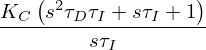

In [9]:
K_C, tau_I, tau_D = sympy.symbols('K_C, tau_I, tau_D', positive=True, nonzero=True)
PID = K_C*(1 + 1/(tau_I*s) + tau_D*s)
PID.expand().together()

Aunque la forma anterior no es realizable debido a la acción derivativa. Por esta razon, es común usar la forma:

$$K_C\left ( 1 + \frac{1}{\tau_I s}+ \frac{\tau_D s}{\alpha \tau_I s+1} \right )$$

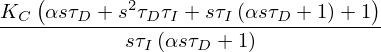

In [10]:
alpha = sympy.symbols('alpha')
ISA = K_C*(1 + 1/(tau_I*s) + tau_D*s/(alpha*tau_D*s + 1))
ISA.expand().together().simplify()

El objetivo es hallar los parámetros del compensador para satisfacer la expresión racional $G_C$

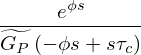

In [11]:
G_C_rational

Se requiere un modelo de proceso $G_p$. En este ejemplo se usará un modelo de segundo orden con tiempo muerto.

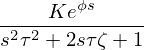

In [12]:
K, tau, zeta, phi,= sympy.symbols('K, tau, zeta, phi', positive=True)
G2 = K*sympy.exp(phi*s)/((tau*s)**2 + 2*tau*zeta*s + 1)
G2

Se incorpora el modelo del sistema a la expresión del compensador.

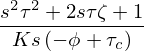

In [13]:
target_G_C = G_C_rational.subs(GPtilde, G2).expand().together()
target_G_C

Se buscan los parámetros del PID que conformen el compensador despejado.

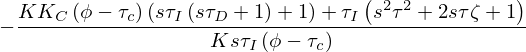

In [14]:
# diferencia entre compensadores determinados
zeroeq = (target_G_C - PID).simplify()
zeroeq

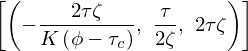

In [15]:
numer, denom = zeroeq.as_numer_denom()
eq = sympy.poly(numer, s)
eqs = eq.coeffs()
sympy.solve(eqs, [K_C, tau_D, tau_I])

La solución obtenida muestra:

$$K_C = -\frac{2\tau \zeta}{K(\phi-\tau_C)}$$
$$\tau_D = \frac{\tau}{2\zeta}$$
$$\tau_I = 2\tau\zeta$$


Los parámetros del compensador quedan completamente definidos a partir de un modelo aproximado del proceso

$$\frac{K}{(\tau s)^2 + 2\tau \zeta s + 1} \cdot e^{s\phi}$$

Y una respuesta deseada

$$\frac{e^{\phi s}}{\tau_c s + 1}$$

**Ejemplo**

Ajuste un controlador PID para un sistema que fue excitado con un escalón unitario y su respuesta fue registrada.

In [16]:
GP = control.tf([1, 2], [2, 3, 4, 1])
GP


TransferFunction(array([1, 2]), array([2, 3, 4, 1]))

In [17]:
df = pd.read_csv('Datos\DatoEscalon.csv')
df.head()

,Unnamed: 0,tiempo,U,Y
0,0,0.000000,1.0,4.985524
1,1,0.196392,1.0,5.046934
2,2,0.392785,1.0,5.125427
3,3,0.589177,1.0,5.159065
4,4,0.785569,1.0,5.211460


In [18]:
ym = df.Y
ts = df.tiempo
interact(resultplot2, K=(0.0, 10.0), tau=(0., 10.), 
         theta=(0., 10.), zeta = (0, 10.0), y0=(0., 10.));

interactive(children=(FloatSlider(value=5.0, description='K', max=10.0), FloatSlider(value=5.0, description='t…

In [19]:
p_inicial = [2, 1, 1.1, 0.5, 4.9]
[K_1, tau_1, zeta_1, theta_1, y0_1], pcov = scipy.optimize.curve_fit(sopdt, ts, ym, p_inicial)
[K_1, tau_1, zeta_1, theta_1, y0_1]

Se define el comportamiento deseado.

In [20]:
tauC = 2

Se calculan los parámetros del PID 

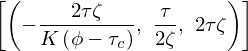

In [21]:
sympy.solve(eqs, [K_C, tau_D, tau_I])

In [22]:
KC1 = -2*tau_1*zeta_1/(K_1*(theta_1 - tauC))
TD1 = tau_1/(2*zeta_1)
TI1 = 2*tau_1*zeta_1
[KC1,TI1,TD1]

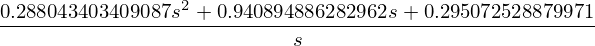

In [23]:
PID1 = KC1*(1 + 1/(TI1*s) + TD1*s)
PID1.expand().together()

In [24]:
GC_PID1 = KC1*(1 + control.tf(1,[TI1,0]) + control.tf([TD1,0],1))
GC_PID1

TransferFunction(array([0.91848118, 3.00022232, 0.94089489]), array([3.18869022, 0.        ]))

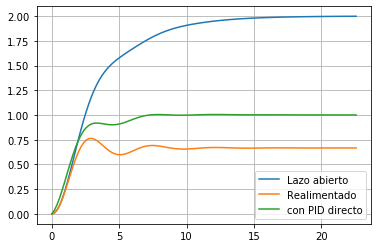

In [25]:
_, yLA = control.step_response(GP,ts)
_, yLC1 = control.step_response(control.feedback(GP,1),ts)
_, yLCPID1 = control.step_response(control.feedback(GC_PID1*GP,1),ts)

plt.plot(ts,yLA,
         ts,yLC1,
         ts,yLCPID1)
plt.legend(('Lazo abierto','Realimentado','con PID directo'))
plt.grid()


Observe que se presentan oscilaciones aunque la respuesta deseada se modeló como un sistema de primer orden con tiempo muerto. 

- ¿A qué se debe esta discrepancia?
- ¿Qué puntos débiles puede tener esta metodología?

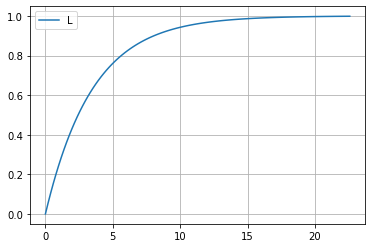

In [28]:
TM = 1.3
TAU = 3.5
GPRUEBA = control.tf([1],[TAU,1])
_, yPRUEBALA = control.step_response(GPRUEBA,ts)
plt.plot(ts,yPRUEBALA)
plt.legend(('Lazo abierto'))
plt.grid()

In [43]:
NUM_TM,DEN_TM = control.pade(TM,2)
TM_TF = control.tf(NUM_TM,DEN_TM)
TM_TF

TransferFunction(array([ 1.        , -4.61538462,  7.10059172]), array([1.        , 4.61538462, 7.10059172]))

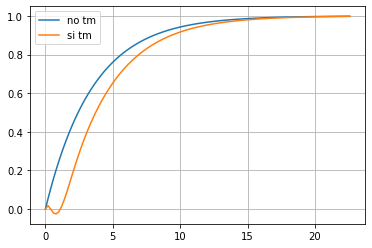

In [44]:
_, yPRUEBALA_TM = control.step_response(GPRUEBA*TM_TF,ts)
plt.plot(ts,yPRUEBALA,ts,yPRUEBALA_TM)
plt.legend(('no tm','si tm'))
plt.grid()

In [45]:
GPRUEBA*TM_TF

TransferFunction(array([ 1.        , -4.61538462,  7.10059172]), array([ 3.5       , 17.15384615, 29.46745562,  7.10059172]))

------

## Reglas de sintonía

[Ziegler y Nichols](https://controlautomaticoeducacion.com/control-realimentado/ziegler-nichols-sintonia-de-control-pid/) propusieron métodos para sintonizar un controlador PID.

### En lazo abierto
El método está desarrollado para sistemas cuya respuesta ante un escalón unitario tienen forma de $S$., es decir, sin sobreimpulsos ni dinámicas inestables. En este caso, el sistema puede aproximarse mediante un modelo de primer orden y tiempo muerto:

$$\frac{K}{\tau s + 1}e^{-Ls}$$


como se muestra en la figura.

<img src="figuras/RespOrden1delay.png" width=500em>

A partir de este modelo, se sugieren los siguientes valores para los compensadores:

| Controlador | $K_C$               | $\tau_I$       | $\tau_D$ |
|-------------|---------------------|----------------|----------|
| P           |$\frac{\tau}{KL}$    | $\infty$       | $0$      |
| PI          |$0.9\frac{\tau}{KL}$ |$\frac{L}{0.3}$ | $0$      |
| PID         |$1.2\frac{\tau}{KL}$ |$2L$            | $0.5L$   |


In [24]:
ym = df.Y
ts = df.tiempo
interact(resultplot1, K=(0.0, 10.0), tau=(0., 10.), 
         theta=(0., 10.), y0=(0., 10.));

interactive(children=(FloatSlider(value=5.0, description='K', max=10.0), FloatSlider(value=5.0, description='t…

In [72]:
p_inicial = [1.8, 2.0, 1.0, 5.0]
[K_2, tau_2, theta_2, y0_2], pcov = scipy.optimize.curve_fit(fopdt, ts, ym, p_inicial)
[K_2, tau_2, theta_2, y0_2]

A partir del modelo, se calculan los parámetros del PID.

$$K_C = 1.2 \frac{\tau}{KL}$$
$$\tau_I = 2 L$$
$$\tau_D = 0.5 L$$


In [73]:
KC2 = 1.2*tau_2/(K_2*theta_2)
TI2 = 2*theta_2
TD2 = 0.5*theta_2
[KC2,TI2,TD2]

In [85]:
KC2,TI2,TD2 = (2.9,1.3,6)

In [86]:
GC_PID2 = KC2*(1 + control.tf(1,[TI2,0]) + control.tf([TD2,0],[0.001*TD2,1]))
GC_PID2

TransferFunction(array([22.64262,  3.7874 ,  2.9    ]), array([0.0078, 1.3   , 0.    ]))

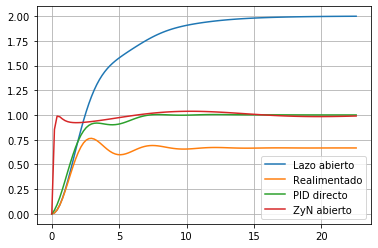

In [87]:

_, yLCPID2 = control.step_response(control.feedback(GC_PID2*GP,1),ts)

plt.plot(ts,yLA,
         ts,yLC1,
         ts,yLCPID1,
         ts,yLCPID2)
plt.legend(('Lazo abierto','Realimentado','PID directo','ZyN abierto'))
plt.grid()


### En lazo cerrado
El método está desarrollado para sistemas que lleguen a oscilación con al ser realimentados. 

Se cierra el lazo eliminando las acciones derivativas e integradoras, es decir, se configura 

$$\tau_I = \infty$$ 
$$\tau_D = 0$$ 

Se varía la ganancia proporcional hasta obtener una respuesta en lazo cerrado que sea una oscilación de amplitud constante. 

- La ganancia del compensador que logra esta respuesta se conoce como ganancia crítica $K_u$.
- El periodo de dicha oscilación es el periodo crítico $P_u$.

Con estos valores se encuentran los parámetros del PID

| Controlador   |	$K_p$   |	 $\tau_I$       |  $\tau_d$     |
|---------------|-----------|-------------------|---------------|
| P	            | $0.5K_u$  | 	$\infty$        |	$0$         |
| PI	        | $0.45K_u$ |$\frac{1}{1.2}P_u$ | 	$0 $        |
| PID	        | $0.6K_u$  | $0.5P_u$          |  $0.125P_u$     |



In [29]:
GP

TransferFunction(array([1, 2]), array([2, 3, 4, 1]))

In [30]:
def resultplotKfeed(K):
    plt.figure(figsize=(21, 7))
    ts = np.linspace(0,5,1000)
    _, yLCPIDk = control.step_response(control.feedback(K*GP,1),ts)
    plt.plot(ts,yLCPIDk)
    plt.grid(True)
    
interact(resultplotKfeed, K=(0.0, 20.0))

interactive(children=(FloatSlider(value=10.0, description='K', max=20.0), Output()), _dom_classes=('widget-int…

<function __main__.resultplotKfeed(K)>

In [31]:
Ku = 9.4
Pu = 2.4
KC3 = 0.6*Ku
TI3 = 0.5*Pu
TD3 = 0.125*Pu
GC_PID3 = KC3*(1 + control.tf(1,[TI3,0]) + control.tf([TD3,0],1))
GC_PID3

TransferFunction(array([2.0304, 6.768 , 5.64  ]), array([1.2, 0. ]))

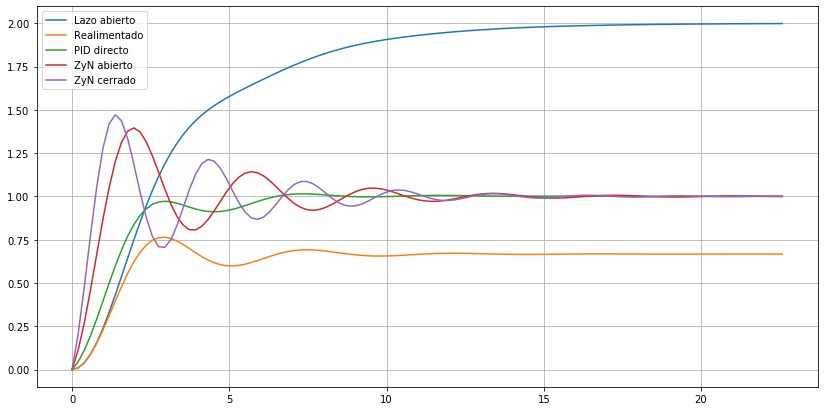

In [32]:
_, yLCPID3 = control.step_response(control.feedback(GC_PID3*GP,1),ts)
plt.figure(figsize=(14, 7))

plt.plot(ts,yLA,
         ts,yLC1,
         ts,yLCPID1,
         ts,yLCPID2,
         ts,yLCPID3)
plt.legend(('Lazo abierto','Realimentado','PID directo','ZyN abierto','ZyN cerrado'))
plt.grid()

<img src="figuras/feedback.png" width=500em>


- ¿Cuál es la función de ransferencia en lazo cerrado desde la Referencia hacia le señal de control?


$$\frac{Y}{Y_{sp}} = \frac{G_C G_P}{1+G_C G_P}$$

$$E = Y_{sp}-Y$$
$$E + Y = Y_{sp}$$
$$Y = Y_{sp}- E$$
$$Y = Y_{sp}- \frac{U}{G_C}$$

$$U = E G_C$$
$$Y = U G_P$$
$$Y_{sp}- \frac{U}{G_C} = U G_P$$
$$Y_{sp} = U G_P +  \frac{U}{G_C}$$
$$Y_{sp} = U (G_P +  \frac{1}{G_C})$$
$$Y_{sp} = U (\frac{G_C G_P}{G_C} +  \frac{1}{G_C})$$
$$Y_{sp} = U (\frac{G_C G_P + 1}{G_C})$$
$$\frac{Y_{sp}}{U} = (\frac{G_C G_P + 1}{G_C})$$


In [33]:
GC_PID2/(1+GP*GC_PID2)

TransferFunction(array([1.01447947e-03, 3.10555304e+00, 1.41318809e+01, 2.76552419e+01,
       3.13535724e+01, 1.92088317e+01, 3.61798230e+00, 0.00000000e+00]), array([3.66567246e-07, 2.24150277e-03, 3.42880033e+00, 6.69490862e+00,
       1.46919161e+01, 1.48042527e+01, 7.23596460e+00, 0.00000000e+00]))

- ¿Cómo se comportan los distintos controladores ante una señal escalón?

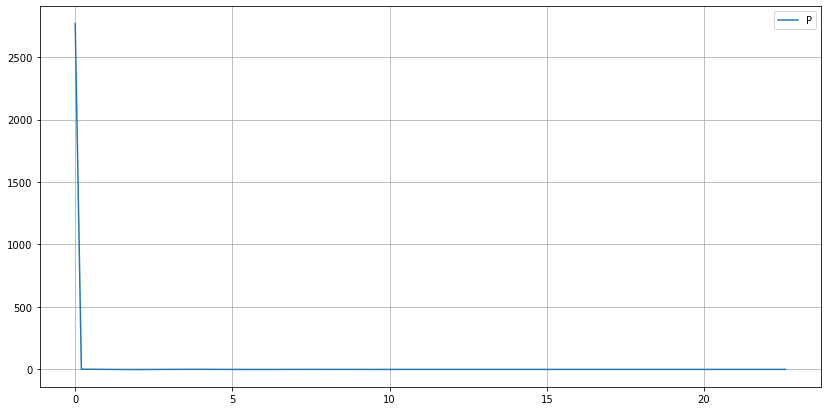

In [34]:
# código necesario

_, uLCPID1 = control.step_response(control.feedback(sys1=GC_PID2,
                                                    sys2=GP),ts)
plt.figure(figsize=(14, 7))

plt.plot(ts,uLCPID1)
plt.legend(('PID directo'))
plt.grid()

## Sintonización basada en criterios integrales

El comportamiento de los lazos de control puede evaluarse mediante la señal de error $e(t) = ref(t) - Y(t)$. A continuación algunos índices basados en el error.

| Índice                                               |        Definición          |
|------------------------------------------------------|------------------------------|
| IAE:Integral del valor absoluto del error            |   $$\int_0^\infty |e(t)|dt$$ |
| ISE:Integral del cuadrado del error                  |   $$\int_0^\infty e(t)^2dt$$ |
| ITAE:Integral de tiempo por valor absoluto del error |   $$\int_0^\infty t|e(t)|dt$$|

Una técnica de diseño consiste en encontrar los parámetros de un compensador PID que minimicen alguno de los índices mencionados con base en un modelo para el sistema. Puede explorar más [aquí](https://www.researchgate.net/publication/260058488_METODOS_DE_SINTONIZACION_DE_CONTROLADORES_PID_QUE_OPERAN_COMO_SERVOMECANISMOS), [aquí](https://www.researchgate.net/publication/260058590_Optimizacion_del_desempeno_de_los_reguladores_y_servomecanismos_PID) y [aquí](https://www.researchgate.net/publication/255641510_SINTONIZACION_DE_CONTROLADORES_PI_Y_PID_UTILIZANDO_LOS_CRITERIOS_INTEGRALES_IAE_E_ITAE)




- Encuentre y simule un controlador PID que minimice el índice ITAE para el sistema

In [35]:
GP

TransferFunction(array([1, 2]), array([2, 3, 4, 1]))

In [36]:
# código necesario

- ¿Cómo se comportan los distintos controladores ante una señal escalón?

In [37]:
# código necesario